## Import Libraries and Data

In [18]:
import PipettingMassBalance as pmb
import pandas as pd
%matplotlib notebook

speciesList = pmb.PipettingSpecies.readCSV('SpeciesDictionary.csv')
instructions = pmb.PipettingInstructions.readCSV('DoE_csv/MasterDataset_OT_DoE_10-14-03-23.csv', firstRow=174, lastRow=180)
targetVolume = 10
sampleList = pmb.PipettingSample.createSamples(instructions,targetVol=targetVolume)
maxVolume = 1
for sample in sampleList:
    sample.getTotalDensity(speciesDictionary=speciesList)
    sample.getVolFracSeries(speciesDictionary=speciesList)
steps = pmb.PipettingStep.createSteps(instructions=instructions,speciesDictionary=speciesList,sampleList=sampleList,maxVol=maxVolume)

massProfile = pmb.MassProfile('mass_data/MassProfile_140323_S175-180.csv',t_baseline=25,derivNoise=0.005,secDerivNoise=0.001)

## Analyse Water Addition

In [19]:
(water_mass,t1)=massProfile.analyseWater(avg_window=10,bl_mult=5)
water=pmb.PipettingSpecies.getSpecies(speciesList, 'water')
water_volume_act=water.getVolume(water_mass)
water_volume_set=0
for sample in sampleList:
    water_volume = sample.waterVol
    water_volume_set = water_volume_set + water_volume
    sample.actualMass = water_volume/water.density
print("This equals a volume of " + str(round(water_volume_act,3)) + "m; expected was "\
      + str(round(water_volume_set,3)) + "mL; error is " + str(round(abs((water_volume_set-water_volume_act)/water_volume_set)*100,3)) + "%")

Water Transfer started at t=86s and ended at t=504s; mass=44.4751g
This equals a volume of 44.564m; expected was 44.855mL; error is 0.649%


## Analyse Surfactants

Peak threshold for 1st derivative = 0.001 g/s and for 2nd derivative = 0.0002 g/s^2


<IPython.core.display.Javascript object>


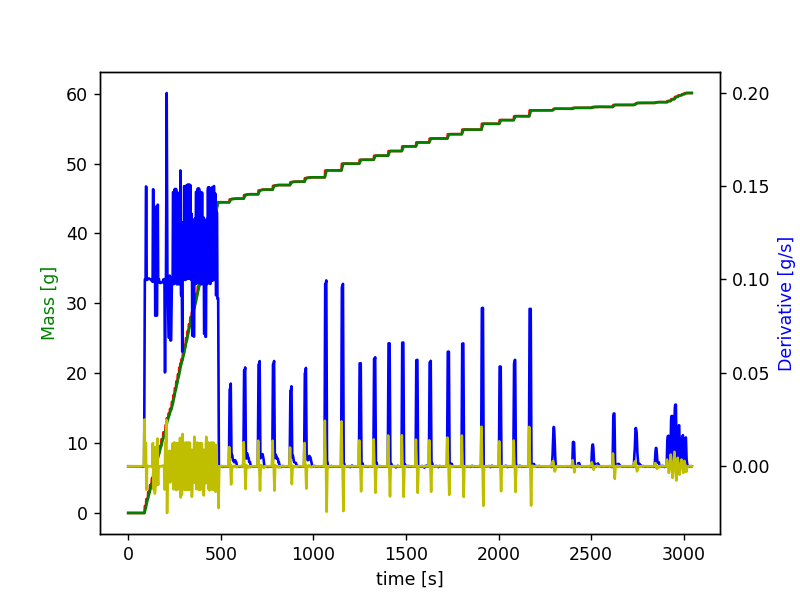

Addition of 0.526g Plantacare 818 detected from 542s to 592s - expected volume = 0.577mL and actual volume = 0.484mL (resulting error is 16.21%)
Addition of 0.629g Plantacare 818 detected from 620s to 666s - expected volume = 0.577mL and actual volume = 0.578mL (resulting error is 0.159%)
Addition of 0.664g Plantacare 818 detected from 698s to 740s - expected volume = 0.587mL and actual volume = 0.615mL (resulting error is 4.767%)
Addition of 0.66g Plantacare 818 detected from 776s to 822s - expected volume = 0.587mL and actual volume = 0.611mL (resulting error is 4.246%)
Addition of 0.489g Plantacare 2000 detected from 870s to 914s - expected volume = 0.531mL and actual volume = 0.453mL (resulting error is 14.62%)
Addition of 0.628g Plantacare 2000 detected from 948s to 998s - expected volume = 0.531mL and actual volume = 0.582mL (resulting error is 9.642%)
Addition of 0.994g Dehyton PK 45 detected from 1058s to 1084s - expected volume = 0.976mL and actual volume = 0.938mL (resulting 

In [20]:
t2 = massProfile.analyseIngredients(avg_window=5, bl_mult=5, mergeSens=10, specType='surfactant', steps=steps,start_idx=t1,show=True)

## Analyse Polyelectrolytes

Peak threshold for 1st derivative = 0.00125 g/s and for 2nd derivative = 0.00025 g/s^2


<IPython.core.display.Javascript object>


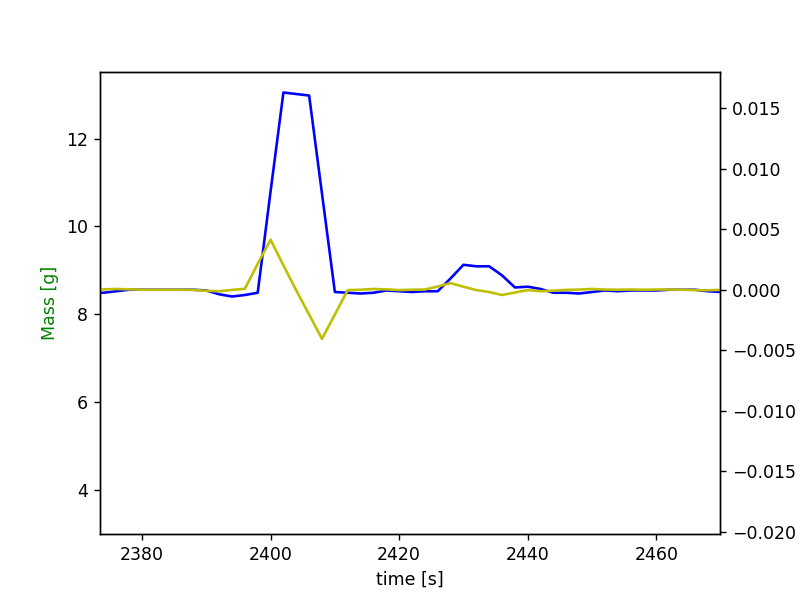

Addition of 0.228g Luviquat Excellence detected from 2286s to 2312s - expected volume = 0.239mL and actual volume = 0.207mL (resulting error is 13.213%)
Addition of 0.141g Luviquat Excellence detected from 2396s to 2440s - expected volume = 0.116mL and actual volume = 0.128mL (resulting error is 10.63%)
Addition of 0.141g Luviquat Excellence detected from 2498s to 2542s - expected volume = 0.121mL and actual volume = 0.127mL (resulting error is 4.851%)
Addition of 0.291g Luviquat Excellence detected from 2614s to 2654s - expected volume = 0.268mL and actual volume = 0.261mL (resulting error is 2.55%)
Addition of 0.285g Luviquat Excellence detected from 2728s to 2766s - expected volume = 0.258mL and actual volume = 0.258mL (resulting error is 0.0%)
Addition of 0.116g Luviquat Excellence detected from 2840s to 2872s - expected volume = 0.091mL and actual volume = 0.104mL (resulting error is 13.848%)


In [30]:
# default bl_mult = 5, default mergeSens = 5
t3 = massProfile.analyseIngredients(avg_window=4, bl_mult=5, mergeSens=8, specType='polyelectrolyte',steps=steps,start_idx=t2,show=True)

## Analyse Thickeners

Peak threshold for 1st derivative = 0.005 g/s and for 2nd derivative = 0.001 g/s^2


<IPython.core.display.Javascript object>


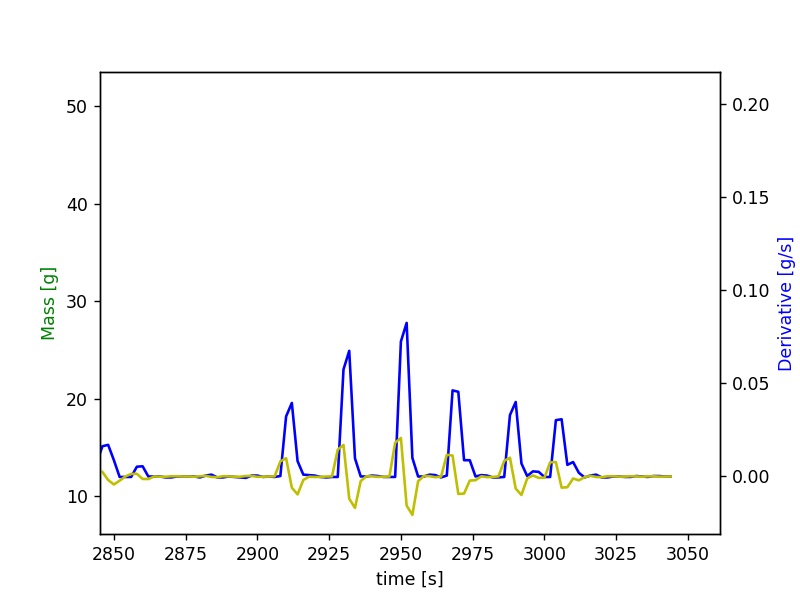

Addition of 0.165g Arlypon TT detected from 2906s to 2920s - expected volume = 0.175mL and actual volume = 0.172mL (resulting error is 1.497%)
Addition of 0.269g Arlypon TT detected from 2926s to 2940s - expected volume = 0.267mL and actual volume = 0.283mL (resulting error is 6.126%)
Addition of 0.331g Arlypon TT detected from 2946s to 2960s - expected volume = 0.325mL and actual volume = 0.344mL (resulting error is 5.591%)
Addition of 0.222g Arlypon TT detected from 2964s to 2980s - expected volume = 0.187mL and actual volume = 0.23mL (resulting error is 22.928%)
Addition of 0.169g Arlypon TT detected from 2984s to 2998s - expected volume = 0.131mL and actual volume = 0.176mL (resulting error is 33.73%)
Addition of 0.158g Arlypon TT detected from 3000s to 3016s - expected volume = 0.134mL and actual volume = 0.163mL (resulting error is 21.538%)


In [25]:
t4 = massProfile.analyseIngredients(avg_window=1, bl_mult=5, mergeSens=1, specType='thickener',steps=steps,start_idx=t3,show=True)

## Consolidate results and create output

In [ ]:
for step in steps:
    step.addToSample()
actualMassFractions = pd.DataFrame(dtype='float64').reindex_like(instructions)
actualMassFractions[:]=0
for i in range(len(sampleList)):
    actualMassFractions['ID'].iloc[i] = sampleList[i].sampleId
    for entry in sampleList[i].addedMassSeries.iteritems():
        actualMassFractions[entry[0]].iloc[i] = entry[1]/sampleList[i].actualMass*100
actualMassFractions.to_csv('mass_data/FreshlyAnalysed_140323_S169-S174.csv', index=False)
actualMassFractions